# Прикладная статистика

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as st
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')

## Доверительные интервалы

### Task 1

Построим гистограмму - зависимость количества проданной пиццы от дней недели и выведем те дни недели, в которых продано *больше* всего и *меньше* всего пиццы


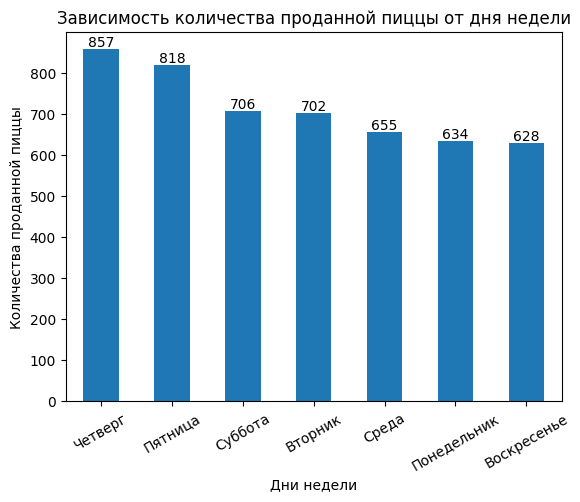

Больше всего пиццы продано в Четверг - 857
Меньше всего пиццы продано в Воскресенье - 628


In [3]:
df_pizza = pd.read_csv('../datasets/pizza.csv', low_memory=False, sep=';', parse_dates=[['order_date', 'order_time']])
df_pizza.rename(columns = {'order_date_order_time':'date_time'}, inplace=True)
df_pizza['day_week'] = df_pizza['date_time']. dt.day_name (locale = 'Russian')
#df_pizza.head()

df_sum = pd.DataFrame(columns=['day_week', 'sum'])
df_sum['day_week'] = df_pizza['day_week'].value_counts().index
df_sum['sum'] = df_pizza['day_week'].value_counts().values
#df_sum

ax = df_sum.plot.bar(x='day_week', y='sum', legend= False)
plt.title('Зависимость количества проданной пиццы от дня недели')
plt.xlabel('Дни недели')
plt.ylabel('Количества проданной пиццы')
plt.xticks(rotation=30)
plt.bar_label(ax.containers[0])
plt.show()

print('Больше всего пиццы продано в', df_sum.iloc [0]['day_week'], '-', df_sum.iloc [0]['sum'])
print('Меньше всего пиццы продано в', df_sum.iloc [6]['day_week'], '-', df_sum.iloc [6]['sum'])

### Task 2

Добавим новый столбец `cook_time`, содержащий время приготовлнения пиццы в *секундах* для каждого заказа \
Посчитаем и выведем среднее, медианное, максимальное и минимальное время затраченное на приготовления пиццы

In [4]:
df_pizza['lead_time'] = pd.to_datetime(df_pizza['lead_time'])
df_pizza['cook_time'] = (df_pizza['lead_time'] - df_pizza['date_time']).dt.seconds
#df_pizza.info()

print('Среднее время приготовления пиццы      -', round(df_pizza['cook_time'].mean()), 'сек.')
print('Медианное время приготовления пиццы    -', round(df_pizza['cook_time'].median()), 'сек.')
print('Максимальное время приготовления пиццы -', round(df_pizza['cook_time'].max()), 'сек.')
print('Минимальное время приготовления пиццы  - ', round(df_pizza['cook_time'].min()), 'сек.')

Среднее время приготовления пиццы      - 1007 сек.
Медианное время приготовления пиццы    - 1006 сек.
Максимальное время приготовления пиццы - 1609 сек.
Минимальное время приготовления пиццы  -  444 сек.


### Task 3

Использую **numpy.std(ddof=1)** для расчёта стандартного отклонения, построим 95% доверительный интервал среднего времени изготовления пиццы

In [ ]:
cook_time = df_pizza['cook_time']
#cook_time.info()

def confidence_interval(df):
    dev = (np.std(df, ddof=1) / np.sqrt(len(df)))
    t_1, t_2 = st.norm.interval(alpha=0.95, loc=np.mean(df), scale=dev)
    return round(t_1), round(t_2)

print('95% доверительный интервал для среднего времени приготовления пиццы в секундах -', confidence_interval(cook_time))

### Task 4

Чтоб оптимизировать меню, владелец пиццерий хочет учитывать время изготовления пиццы при определении её цены, поэтому необходимо найти и вывести название пиццы, у которой самая высокая верхняя граница доверительного интервала для времени изготовления \
Учитываем только пиццы, которые заказывали более 100 раз

In [5]:
df_100 = df_pizza[df_pizza['pizza_name'].map(df_pizza['pizza_name'].value_counts()) > 100]
#df_100
pizza_cihigh = {}

for name_pizza in df_100['pizza_name']:
    pizza_i = df_100[df_100['pizza_name'] == name_pizza]
    ci = st.t.interval(alpha=0.95 , df=len(pizza_i)-1, loc=pizza_i['cook_time'].mean(),
                       scale=pizza_i['cook_time'].std(ddof=1)/np.sqrt(len(pizza_i)))
    pizza_cihigh[name_pizza] = (round(ci[1]))
#pizza_cihigh

print('У пиццы', max(pizza_cihigh, key=pizza_cihigh.get),
      'самая высокая верхняя граница доверительного интервала её изготовления -', max(pizza_cihigh.values()))

У пиццы The Italian Vegetables Pizza самая высокая верхняя граница доверительного интервала её изготовления - 1069


### Task 5

Владелец сети хочет исключить из меню пиццу с нестабильным временем изготовления, для этого нужно найти и вывести название пиццы с самым широким доверительным интервалом для времени изготовления \
Учитываем только пиццы, которые заказывали более 100 раз

In [6]:
pizza_ciwide = {}

for name_pizza in df_100['pizza_name']:
    pizza_i = df_100[df_100['pizza_name'] == name_pizza]
    ci = st.t.interval(alpha=0.95 , df=len(pizza_i)-1, loc=pizza_i['cook_time'].mean(),
                       scale=pizza_i['cook_time'].std(ddof=1)/np.sqrt(len(pizza_i)))
    pizza_ciwide[name_pizza] = (round(ci[1] - ci[0]))
#pizza_ciwide

print('У пиццы', max(pizza_ciwide, key=pizza_ciwide.get),
      'самый широкий доверительный интервал её изготовления -', max(pizza_ciwide.values()))

У пиццы The Chicken Alfredo Pizza самый широкий доверительный интервал её изготовления - 73


## AB тестирование

### Task 6

Проанализируем результаты голосования: нулевая гипотеза (H0) - старый баннер (`banner_a`) лучше; альтернативная гипотеза (H1) - новый баннер (`banner_b`) лучше \
Используя метод **proportion_confint** библиотеки **statsmodels** построим 95% доверительные интервалы для доли старого и нового баннеров и посмотрим пересекаются ли они

In [7]:
df_click = pd.read_csv('../datasets/click.csv', low_memory=False)
#df_click

ci_banner_a = proportion_confint(df_click['banner_a'].sum(), df_click.shape[0])
ci_banner_b = proportion_confint(df_click['banner_b'].sum(), df_click.shape[0])

print('Доверительный интервал для доли старого баннера -', ci_banner_a)
print('Доверительный интервал для доли нового баннера -', ci_banner_b)

if (ci_banner_a[0] <= ci_banner_b[1]) | (ci_banner_b[0] <= ci_banner_a[1]):
    print('Интервалы пересекаются')
else:
    print('Интервалы не пересекаются')

Доверительный интервал для доли старого баннера - (0.02530064022092865, 0.04869935977907135)
Доверительный интервал для доли нового баннера - (0.03911451622486782, 0.06688548377513218)
Интервалы пересекаются


### Task 7

Для улучшения качества оценки построим  95% доверительный интервал для разности двух долей

scipy.stats.norm.ppf(q, loc=0, scale=1) \
Левую и правую границы доверительного интервала рассчитываем по формулам:
$$p_a - p_b \pm z * \sqrt{\frac{p_a(1 - p_a)}{n_a} + \frac{p_b(1 - p_b)}{n_b}}$$
Где

$p_a = \frac{n_{like(a)}}{n_{a}}$

$p_b = \frac{n_{like(b)}}{n_{b}}$

$z = 1-\frac{\alpha}{2}$ (используем **scipy.stats.norm.ppf**)

$n_a$ - количество кликов по `banner_a`

$n_b$ - количество кликов по `banner_b`

$n_{like(a)}$ - количество лайков `banner_a`

$n_{like(b)}$ - количество лайков `banner_b`

In [8]:
def ci_diff(sample1, sample2):
    z =  scipy.stats.norm.ppf(1-0.05/2)
    
    p_a = sum(sample1) / len(sample1)
    p_b = sum(sample2) / len(sample2)
    left_b = p_a - p_b - z * np.sqrt(p_a*(1-p_a)/len(sample1) + p_b*(1-p_b)/len(sample2))
    right_b = p_a - p_b + z * np.sqrt(p_a*(1-p_a)/len(sample1) + p_b*(1-p_b)/len(sample2))
    
    return[round(left_b, 5), round(right_b, 5)]

print('95% доверительный интервал для разности двух долей:', ci_diff(df_click['banner_a'], df_click['banner_b']))

95% доверительный интервал для разности двух долей: [-0.03416, 0.00216]


### Task 8

Проведём, собственно, *A/B тест* и выясним какую гипотезу H0 или H1 принимаем

В этом тебе поможем функция *z-критерия*
 $$Z({X_1, X_2}) =  \frac{p_a - p_b}{\sqrt{P(1 - P)(\frac{1}{n_a} + \frac{1}{n_b})}}$$
$$P = \frac{p_a{n_a} + p_b{n_b}}{{n_a} + {n_b}} $$
Где

$p_a, p_b = \frac{∑кликов}{n}$

$n$ - общее количество кликов по баннерам

$n_a$ - количество кликов по `banner_a`

$n_b$ - количество кликов по `banner_b`

In [9]:
def z_stat(sample1, sample2):
    n_a = len(sample1)
    n_b = len(sample2)

    p_a = float(sum(sample1)) / n_a
    p_b = float(sum(sample2)) / n_b 
    P = float(p_a * n_a + p_b * n_b) / (n_a + n_b)
  
    return (p_a - p_b) / np.sqrt(P * (1 - P) * (1. / n_a + 1. / n_b))


In [10]:
zscore = z_stat(df_click['banner_a'], df_click['banner_b'])
pvalue = round(stats.norm.sf(np.abs(zscore)), 5)

if pvalue <= 0.05:
    print('Новый баннер лучше, принимаем гипотезу H1')
else:
    print('Старый баннер лучше, отвергаем гипотезу H1')

Новый баннер лучше, принимаем гипотезу H1


## Корреляции

### Task 9

Сгенерируем выборки и посчитаем коэффициенты коррелиций **Пирсона** и **Спирмена** для выборок `x-y1`, `x-y2`, `x-y3` \
Отрисуем выборки в таком виде
<img src="../misc/images/corr.png">
Проанализируем значения корреляций

__Коэффициент корреляции Пирсона__ (r-Пирсона) применяется для исследования взаимосвязи двух переменных, измеренных в метрических шкалах на одной и той же выборке. Он позволяет определить, насколько пропорциональная изменчивость двух переменных. Коэффициент корреляции r-Пирсона характеризует существование линейной связи между двумя величинами. Варьируется от 0 до 1.

__Коэффициент ранговой корреляции Спирмена__ (r-Спирмена) применяется для исследования корреляционной взаимосвязи между двумя ранговыми переменными. Позволяет определить тесноту (силу) и направление корреляционной связи между двумя признаками или двумя профилями (иерархиями) признаков.  Варьируется от 0 до 1.

In [11]:
x = np.linspace(-10,10,100)
y1 = x ** 2
y2 = -x **2
y3 = np.log(x ** 2 + 1)

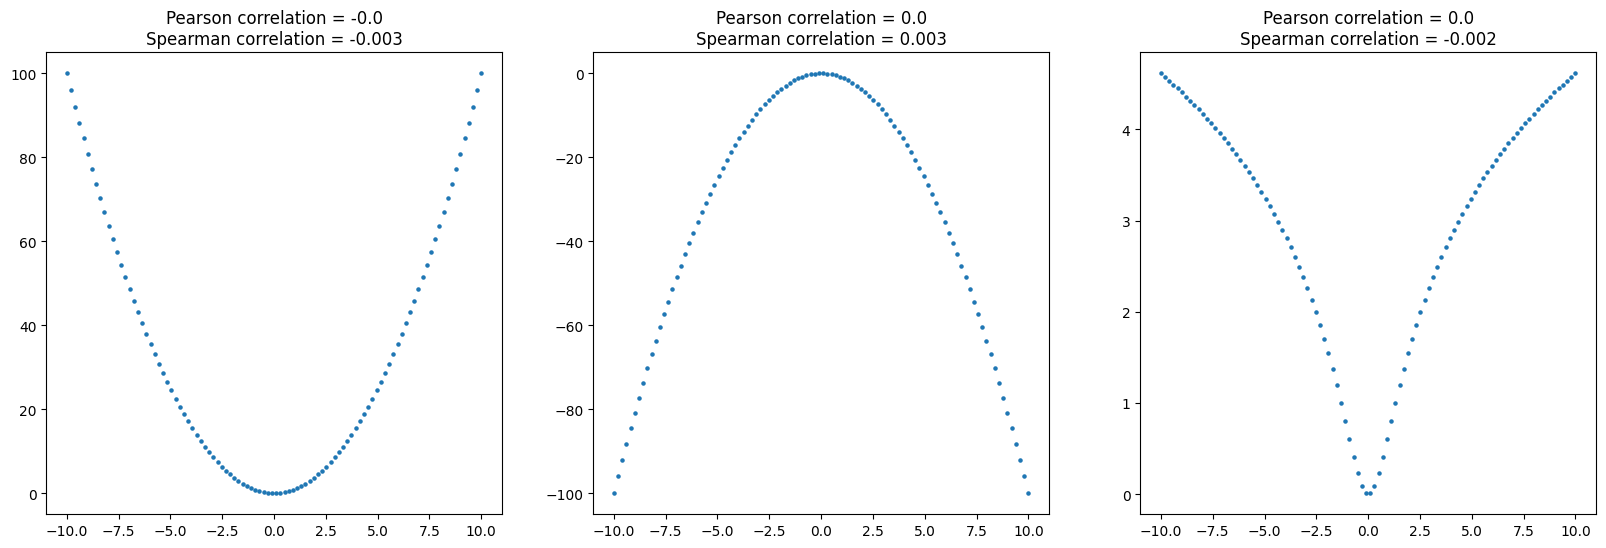

Pearson correlation = 0, т.к. между выборками x и y нет линейной зависимости
Spearman correlation близка к 0, т.к. выборки x и y не ранжированные


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
y = [y1, y2, y3]

for i in range (3):
    ax[i].scatter(x, y[i], s=5)
    ax[i].set_title('Pearson correlation = {}\nSpearman correlation = {}'.
                    format(round(st.pearsonr(x, y[i])[0], 3), round(st.spearmanr(x, y[i])[0], 3)))
    
plt.show()

print('Pearson correlation = 0, т.к. между выборками x и y нет линейной зависимости\n'
     'Spearman correlation близка к 0, т.к. выборки x и y не ранжированные')

### Task 10

Построим облако из тысячи точек и посчитаем коэффициенты корреляций **Пирсона** и **Спирмена** \
Затем, для имитации выбросов, случайным образом выберем четыре точки, каждую из которых будем передвигать в правый верхний угол относительно облака и выведем график облако с выбросами \
Для каждого случая посчитаем коэффициенты корреляций **Пирсона** и **Спирмана** и проанализируем значения корреляций

In [13]:
step = np.linspace(-10, 0, 1000)
x = -step + np.random.randn(1000) * 0.2
y = step + np.random.randn(1000)* 0.2

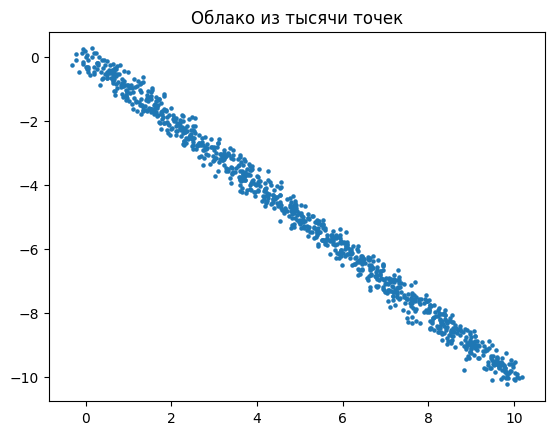

Pearson correlation = -0.996
Spearman correlation = -0.996


In [14]:
plt.scatter(x, y, s=5)
plt.title('Облако из тысячи точек')

plt.show()

print('Pearson correlation = {}\nSpearman correlation = {}'.
          format(round(st.pearsonr(x, y)[0], 3), round(st.spearmanr(x, y)[0], 3)))

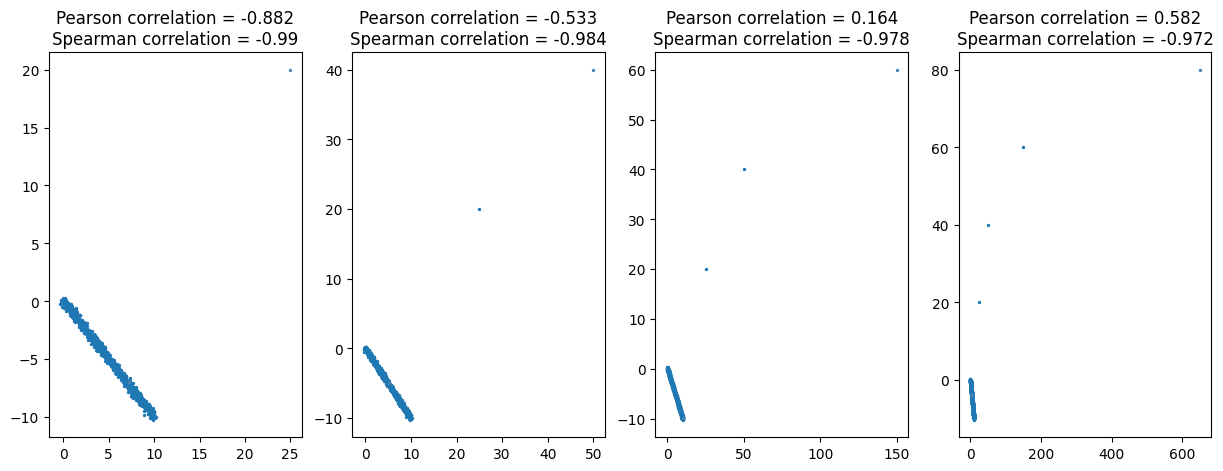

Коэффициент корреляции Спирмана более стабилен, т.к. эта корреляция больше устойчива к выбросам


In [15]:
point = np.random.randint(0, 1000, 4)
x_point = [25, 50, 150, 650]
y_point = [20, 40, 60, 80]
x_p, y_p = x.copy(), y.copy()

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for j in range (4):
    ax[j].scatter(x_p, y_p, s=2)
    ax[j].scatter([x_p[point[j]], x_point[j]], [y_p[point[j]], y_point[j]], s=2, edgecolor ='steelblue')
    x_p[point[j]] = x_point[j]
    y_p[point[j]] = y_point[j]
    ax[j].set_title('Pearson correlation = {}\nSpearman correlation = {}'.
                    format(round(st.pearsonr(x_p, y_p)[0], 3), round(st.spearmanr(x_p, y_p)[0], 3)))
        
plt.show()

print('Коэффициент корреляции Спирмана более стабилен, т.к. эта корреляция больше устойчива к выбросам')